In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Clinical Data

## Load and check clinical data

In [ ]:
# Load data
df_clinical = pd.read_csv('_data/clinical.csv').set_index('pnr')

# Data quality checks
assert len(df_clinical.index.unique()) == len(df_clinical) # One line per patient

# Start date
assert len(df_clinical[df_clinical["start"].isna()]) == 0 # No missing date
df_clinical["start"] = pd.to_datetime(df_clinical["start"]) # No error raise on date format

# Treatment follow-up
assert len(df_clinical[df_clinical["fu_trt"].isna()]) == 0 # No follow-up 
assert len(df_clinical[df_clinical["stopped_trt"].isna()]) == 0 # No boolean
assert len(df_clinical[df_clinical["drug"].isna()]) == 0 # No unknown treatment

print(round(100*df_clinical.isna().sum()/len(df_clinical)))


start           0.0
crp            18.0
pain           24.0
tjc            19.0
sjc            19.0
drug            0.0
fu_trt          0.0
stopped_trt     0.0
dtype: float64


## Study design statistics

In [3]:
# Key stats

# Patients
print(f"{len(df_clinical)} patients")
print(f"Recruited between {df_clinical['start'].min()} and {df_clinical['start'].max()}")

# Drug repartition
percent_A = round(len(df_clinical[df_clinical['drug']=="A"])/len(df_clinical)*100)
percent_B = round(len(df_clinical[df_clinical['drug']=="B"])/len(df_clinical)*100)
print(f"Treatments: A ({percent_A}%), B ({percent_B}%)")

1185 patients
Recruited between 2010-01-05 00:00:00 and 2016-12-27 00:00:00
Treatments: A (58%), B (42%)


In [4]:
# End of follow-up
df_clinical['stop'] = df_clinical['start'] + pd.to_timedelta((df_clinical['fu_trt']*30), unit = 'D')

print(f"Date of censure vary from {df_clinical[df_clinical['stopped_trt'] == 0]['stop'].min()} to {df_clinical[df_clinical['stopped_trt'] == 0]['stop'].max()}")
print(f"Time of follow-up for censure vary from  {df_clinical[df_clinical['stopped_trt'] == 0]['fu_trt'].min()} to {df_clinical[df_clinical['stopped_trt'] == 0]['fu_trt'].max()} months")

Date of censure vary from 2010-06-21 23:59:59.999913600 to 2018-01-31 00:00:00.000864008
Time of follow-up for censure vary from  3.3 to 60.0 months


The handling of date delta that is approximative, and could be further improved. 

Looking on how the data was censored, there might be some informative censoring. In an ideal world I would discuss with clinician or the person who design the study or look for references associated to the data, to better understand recruitment process.

## Clinical data analysis

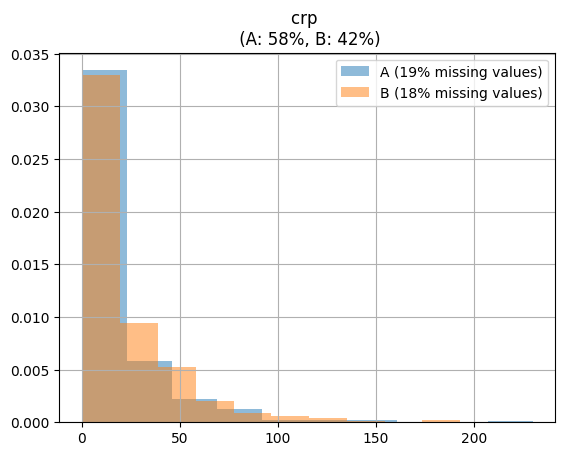

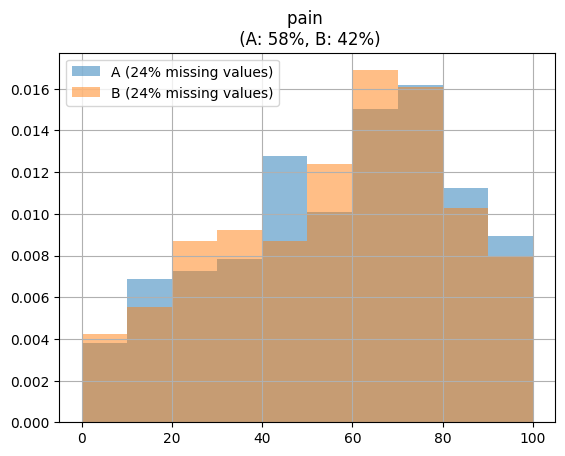

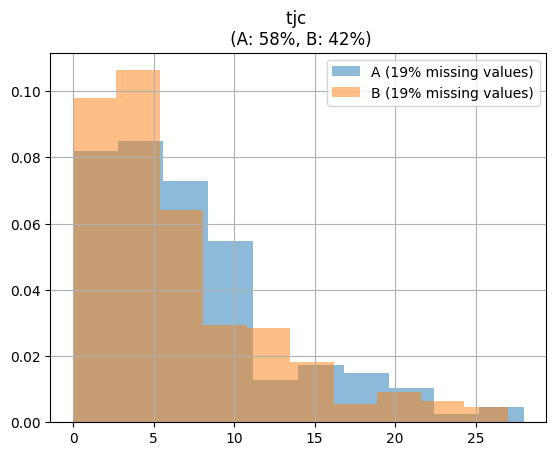

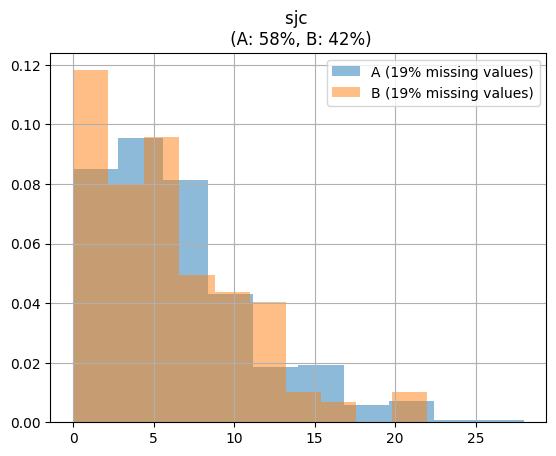

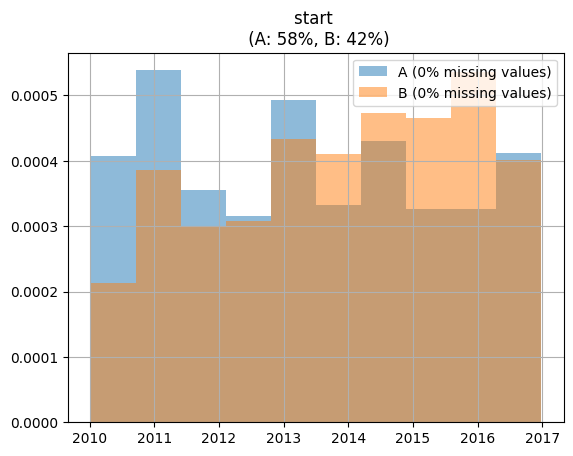

In [5]:
for col_baseline in ['crp', 'pain', 'tjc', 'sjc', 'start']:
    for drug, color in zip(["A", "B"], ["blue", "orange"]):
        df_plot = df_clinical[df_clinical['drug']==drug]
        perc_missing = round(100*df_plot[col_baseline].isna().sum()/len(df_plot))
        df_plot[col_baseline].hist(density = True, alpha = 0.5,
                                   label = f"{drug} ({perc_missing}% missing values)")
    plt.title(f"{col_baseline} \n (A: {percent_A}%, B: {percent_B}%)")
    plt.legend()
    plt.show()

At a first glance, patients caracteristics do not seems really different comparing the two treatments. Nevertheless, in terms of incidence of treatment use there seems to be differences. Maybe treatment B was introduced later than treatment A, that would be something to discuss with experts or to look in litterature. 

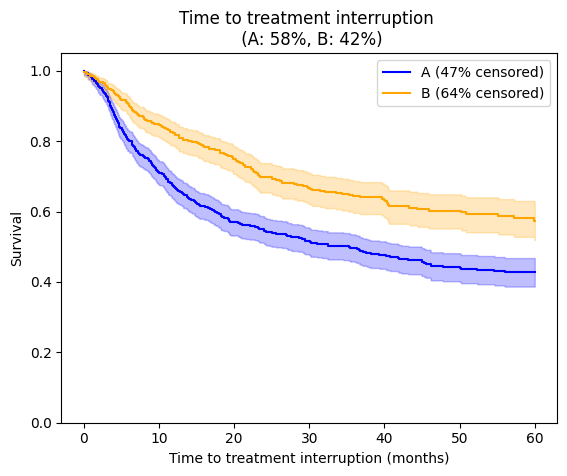

In [6]:
for drug, color in zip(["A", "B"], ["blue", "orange"]):
    df_plot = df_clinical[df_clinical['drug']==drug]
    percent_pop = round(len(df_plot)/len(df_clinical)*100)
    censoring_rate = round((1 - df_plot['stopped_trt'].sum()/len(df_plot))*100)
    kmf = KaplanMeierFitter(label=f"{drug} ({censoring_rate}% censored)")
    kmf.fit(df_plot['fu_trt'], df_plot['stopped_trt'])
    kmf.plot(color = color)
plt.xlabel('Time to treatment interruption (months)')
plt.ylabel('Survival')
plt.title(f'Time to treatment interruption \n (A: {percent_A}%, B: {percent_B}%)')
plt.ylim(0,1.05)
plt.show()

Here by using Kaplan Meier we assume non informative censoring, but this hypothesis could be discussed given the recruitment process. 

# Patients historic

## Load and check data indatum

In [ ]:
df_inpatient = pd.read_csv('_data/inpatient.csv')

# Start date
assert len(df_inpatient[df_inpatient["indatum"].isna()]) == 0 # No missing date
df_inpatient["indatum"] = pd.to_datetime(df_inpatient["indatum"]) # No error raise on date format

# End date date
assert len(df_inpatient[df_inpatient["utdatum"].isna()]) == 0 # No missing date
df_inpatient["utdatum"] = pd.to_datetime(df_inpatient["utdatum"]) # No error raise on date format

# Clean dupplicates
df_inpatient = df_inpatient.set_index(['pnr', 'indatum', 'HDIA'])
# Here I consider that a visit could be identified by the patient, date and main diagnosis, 
# but this could be further discussed with clinicians, yet I have visually checked that this 
# was a reasonnable assumption
print(f'{len(df_inpatient[df_inpatient.index.duplicated()])} visits duplicated droped')
df_inpatient = df_inpatient[~df_inpatient.index.duplicated()]
df_inpatient = df_inpatient.reset_index(['indatum', 'HDIA'])

# Missing data and diagnosis
print(round(100*df_inpatient.isna().sum()/len(df_inpatient)))
print(f"For {len(df_inpatient[df_inpatient['DIA01']!=df_inpatient['HDIA']])} visits the HDIA was not the DIA01, but the DIA02")

29 visits duplicated droped
indatum     0.0
HDIA        0.0
DIA01       0.0
DIA02      34.0
DIA03      57.0
DIA04      72.0
DIA05      83.0
DIA06      89.0
utdatum     0.0
dtype: float64
For 12 visits the HDIA was not the DIA01, but the DIA02


## Load and check data outdatum

In [ ]:

df_outpatient = pd.read_csv('_data/outpatient.csv')

# Start date
assert len(df_outpatient[df_outpatient["indatum"].isna()]) == 0 # No missing date
df_outpatient["indatum"] = pd.to_datetime(df_outpatient["indatum"]) # No error raise on date format

# Clean dupplicates
df_outpatient = df_outpatient.set_index(['pnr', 'indatum', 'HDIA'])
# Here I consider that a visit could be identified by the patient, date and main diagnosis, 
# but this could be further discussed with clinicians, yet I have visually checked that this 
# was a reasonnable assumption
print(f'{len(df_outpatient[df_outpatient.index.duplicated()])} visits duplicated droped')
df_outpatient = df_outpatient[~df_outpatient.index.duplicated()]
df_outpatient = df_outpatient.reset_index(['indatum', 'HDIA'])

# Missing data and diagnosis
print(round(100*df_outpatient.isna().sum()/len(df_outpatient)))
print(f"For {len(df_outpatient[df_outpatient['DIA01']!=df_outpatient['HDIA']])} visits the HDIA was not the DIA01, but the DIA02")

713 visits duplicated droped
indatum      0.0
HDIA         0.0
DIA01        0.0
DIA02       81.0
DIA03       95.0
DIA04       98.0
DIA05       99.0
DIA06      100.0
dtype: float64
For 205 visits the HDIA was not the DIA01, but the DIA02


# Study statistics

In [9]:
# Key stats

# Inpatients
print(f"{len(df_inpatient.index.unique())} inpatients with at least one visits")
print(f"Inpatients recruited between {df_inpatient['indatum'].min()} and {df_inpatient['utdatum'].max()}")

# Outpatients
print(f"{len(df_outpatient.index.unique())} outpatients with at least one visits")
print(f"Inpatients recruited between {df_inpatient['indatum'].min()} and {df_inpatient['indatum'].max()}")


1023 inpatients with at least one visits
Inpatients recruited between 1997-01-09 00:00:00 and 2016-12-30 00:00:00
1249 outpatients with at least one visits
Inpatients recruited between 1997-01-09 00:00:00 and 2016-12-28 00:00:00


It seems that the data was extracted from the same time window

# Diagnosis frequency 

In [10]:
list_in_out = []
for name, df_study in zip(['inpatient', 'outpatient'], [df_inpatient, df_outpatient]):
    list_diag = []
    for col_diag in ['HDIA', 'DIA02', 'DIA03', 'DIA04', 'DIA05', 'DIA06']: # not DIA01 as its mainly as HDIA
        
        label_freq = df_study[col_diag].value_counts()
        label_freq = round(100*label_freq/len(df_study))
        #label_freq = label_freq.sort_values(ascending= False).iloc[:10].to_frame()
        label_freq = label_freq[label_freq>=3].to_frame()
        label_freq.columns = [col_diag]
        list_diag.append(label_freq)
    df_diag = pd.concat(list_diag, axis = 1).fillna('-')
    df_diag.columns = pd.MultiIndex.from_product([[name], df_diag.columns ])
    list_in_out.append(df_diag)



In [11]:
pd.concat(list_in_out, axis = 1).fillna('-')

inpatient                               outpatient                    \
           HDIA DIA02 DIA03 DIA04 DIA05 DIA06       HDIA DIA02 DIA03 DIA04   
M059        7.0   6.0   4.0     -     -     -       33.0     -     -     -   
O800A       3.0     -     -     -     -     -          -     -     -     -   
M069          -   5.0   4.0     -     -     -          -     -     -     -   
I109          -   5.0   4.0   3.0     -     -          -     -     -     -   
M060          -     -     -     -     -     -        5.0     -     -     -   
M058          -     -     -     -     -     -        3.0     -     -     -   
M059L         -     -     -     -     -     -        3.0     -     -     -   

                   
      DIA05 DIA06  
M059      -     -  
O800A     -     -  
M069      -     -  
I109      -     -  
M060      -     -  
M058      -     -  
M059L     -     -

This tab present ICD10 code for each type of diagnosis that appear more than 3% of the time, associated with there frequency. What we can see is that some diagnosis such as I109 are mainly given as secondary diagnosis. It could be nice to associated the code with their medical signification and further discuss this tab maybe with clinicians. In addition maybe they could be grouped by there root.

# Incidence

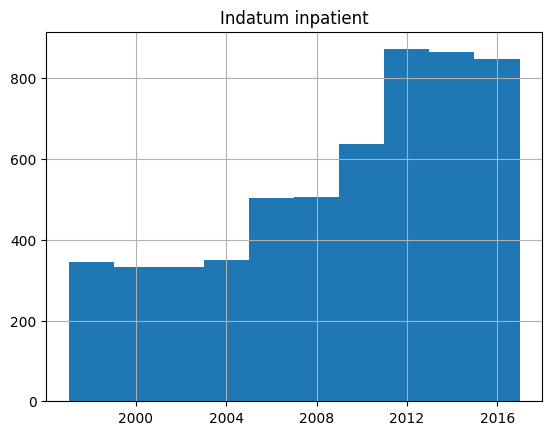

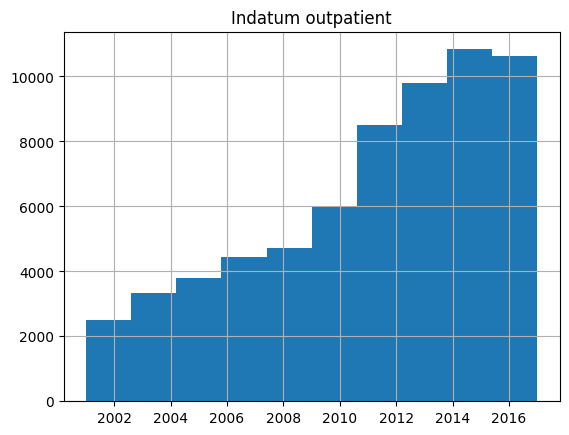

In [12]:
# Inpatients
df_inpatient['indatum'].hist()
plt.title('Indatum inpatient')
plt.show()

# Outpatients
df_outpatient['indatum'].hist()
plt.title('Indatum outpatient')
plt.show()

Incidence is clearly increasing. Should it be corrected by polycies introduction, aging of population? How was the data selected? 